# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

^C


ModuleNotFoundError: No module named 'google'

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration
!mkdir nyc
!unzip train.zip -d nyc
!unzip test.zip -d nyc

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
data = pd.read_csv("nyc/train.csv")
data = data.drop(columns=["dropoff_datetime"])
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])

FileNotFoundError: [Errno 2] File nyc/train.csv does not exist: 'nyc/train.csv'

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [ ]:
plt.hist(data['trip_duration'])
plt.title('Гистограмма времени поездки')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Выбросы всё портят.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Потому что время поездки может быть довольно долгим, а RMSLE, в отличие от RMSE, учитывает относительную, а не абсолютную, ошибку.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: $\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{x}_i\big)^2} $; а $y_i$ - вполне себе монотонная функция. Поэтому минимизация одного ведёт к минимазации другого.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [ ]:
data['log_trip_duration'] = data['trip_duration'].apply(np.log1p)
#data = data.drop(columns=['trip_duration']) // если надо удалить, вообще она еще позже нужна
plt.hist(data['log_trip_duration'])
plt.title('Гистограмма логарифмов времени поездки')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
best_constant = data['log_trip_duration'].mean()
print(best_constant)

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [ ]:
data['pickup_date'] = data['pickup_datetime'].dt.date
plt.figure(figsize=(35,5))
plt.xticks(rotation=90)
sns.countplot(data=data.sort_values(by='pickup_date'), x = 'pickup_date')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

23-24 января в связи с ураганом официально было запрещено движение в Нью-Йорке. Второй период - в конце мая - является загадкой.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
import calendar


# def localize_weekday(num):
#   return calendar.day_name[num]

# def localize_month(num):
#   return calendar.month_name[num]

data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_month'] = data['pickup_datetime'].dt.month

sns.relplot(data=data.groupby('pickup_weekday').count()['pickup_hour'], kind="line", height=8, aspect=1)
sns.relplot(data=data.groupby('pickup_hour').count()['pickup_weekday'], kind="line", height=8, aspect=1)

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [ ]:
plot_data_month = data.groupby(['pickup_hour', 'pickup_month']).count()
plot_data_month.reset_index(inplace=True)
sns.relplot(data=plot_data_month, x="pickup_hour", y="id", hue="pickup_month", kind="line", height=8, aspect=1, palette=sns.color_palette("hls", len(plot_data_month['pickup_month'].unique())))
plot_data_weekday = data.groupby(['pickup_hour', 'pickup_weekday']).count()
plot_data_weekday.reset_index(inplace=True)
sns.relplot(data=plot_data_weekday, x="pickup_hour", y="id", hue="pickup_weekday", kind="line", height=8, aspect=1, palette=sns.color_palette("hls", len(plot_data_weekday['pickup_weekday'].unique())))

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Из дней недели выделяются выходные (более свободное движение). Из месяцев - особо ничего. Из времени суток - ночь, когда, по понятным причинам, поездок намного меньше.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
from sklearn.model_selection import train_test_split
from datetime import datetime

def get_num_of_day(_date):
  return _date.timetuple().tm_yday


data['pickup_num_of_day'] = data['pickup_datetime'].apply(get_num_of_day)

data = data.drop(columns=['pickup_date'])

train, test = train_test_split(data, test_size=0.3, random_state=413)

x_train = train.drop(columns=["log_trip_duration"])
x_test = test.drop(columns=["log_trip_duration"])
y_train = train[['log_trip_duration']]
y_test = test[['log_trip_duration']]


sns.relplot(data=train.groupby(['pickup_weekday']).mean(), x="pickup_weekday", y="log_trip_duration", kind="line", height=8, aspect=1)

sns.relplot(data=train.groupby(['pickup_hour']).mean(), x="pickup_hour", y="log_trip_duration", kind="line", height=8, aspect=1)

sns.relplot(data=train.groupby(['pickup_num_of_day']).mean(), x="pickup_num_of_day", y="log_trip_duration", kind="line", height=8, aspect=1)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Да, похожи, т.к. большое количество проездок происходит в часы пик, а это означает пробки, а это означает долгое время поездки по сравнению с теми же дистанциями вне часов пик.

В аномальные периоды таргет падает, поскольку дороги свободны, и мало кто поедет на дальнии дистанции. Зато после - растёт, т.к. всем нужно компенсировать отсутствие поездок в аномальный период.

Зависимости `log_trip_duration` от номера дня в году не наблюдаю, за исключением легкого роста ближе к лету и колебания между выходными / будними.



Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
#все, кроме четвертого, уже добавил. четвертый:

data['is_anomaly_1'] = False
data['is_anomaly_2'] = False

data.loc[((23 < data['pickup_num_of_day']) & (data['pickup_num_of_day'] < 26)), 'is_anomaly_1'] = True
data.loc[((148 < data['pickup_num_of_day']) & (data['pickup_num_of_day'] < 152)), 'is_anomaly_2'] = True

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

День недели и месяц - как категориальные (всего шесть-семь возможных значений, линейную зависимость сложно усмотреть).

Час и номер дня в году - как численные (много возможных значений, у дня в году просматривается легкая линейная зависимость)

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

train, test = train_test_split(data, test_size=0.3, random_state=413)

x_train = train.drop(columns=["log_trip_duration"])
x_test = test.drop(columns=["log_trip_duration"])
y_train = train[['log_trip_duration']]
y_test = test[['log_trip_duration']]

categorical = ['pickup_weekday', 'pickup_month']
numeric = ['pickup_num_of_day', 'pickup_hour']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "red")

**Вопрос**: Какие две точки выделяются на карте?

Точки посадки и высадки

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
!pip install haversine

In [ ]:
from haversine import haversine

def vec_haversine(row):
  return haversine((row['pickup_latitude'], row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']))

data['haversine'] = data.apply(vec_haversine, axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [ ]:
data['haversine_log'] = data['haversine'].apply(np.log1p)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
correlations = data[['haversine', 'haversine_log']].corrwith(data['log_trip_duration']).sort_values()
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
def avg_speed(row):
  return row['haversine'] / row['trip_duration']

data['avg_speed'] = data.apply(avg_speed, axis=1)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [ ]:
data = data[data['avg_speed'] < data['avg_speed'].quantile(.95)]
plt.hist(data['avg_speed'])
plt.title('Гистограмма средней скорости такси')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [ ]:
data_temp = data.groupby(['pickup_weekday', 'pickup_hour']).mean()
data_temp.reset_index(inplace=True)
data_temp = data_temp.pivot(index='pickup_hour', columns='pickup_weekday', values='avg_speed')
plt.figure(figsize=(20,20))
sns.heatmap(data_temp, annot=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что его получили из целевой переменной, воспользовавшись запретным знанием

In [ ]:
data = data.drop(columns='avg_speed')

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

В будние дни в середине дня скорость минимальна, ночью же максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
data['jam_flag'] = False
data['free_flag'] = False

data.loc[(((8 <= data['pickup_hour']) & (data['pickup_hour'] <= 18)) & ((0 <= data['pickup_weekday']) & (data['pickup_weekday'] <= 4))), 'jam_flag'] = True
data.loc[((((0 <= data['pickup_hour']) & (data['pickup_hour'] <= 6)) & ((0 <= data['pickup_weekday']) & (data['pickup_weekday']<= 4))) | (((4 <= data['pickup_hour']) & (data['pickup_hour'] <= 7)) & ((5 <= data['pickup_weekday']) & (data['pickup_weekday'] <= 6)))), 'free_flag'] = True

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [ ]:
#векторно haversine работать не хочет, поэтому придется так :(

jfk_coords = (40.645730, -73.784467)
ee_coords = (40.773130, -73.873494)

def airport_dropoff(row):
  if (haversine((row['dropoff_latitude'], row['dropoff_longitude']), jfk_coords) < 0.5) or (haversine((row['dropoff_latitude'], row['dropoff_longitude']), ee_coords) < 0.5):
    return True
  else:
    return False

def airport_pickup(row):
  if ((haversine((row['pickup_latitude'], row['pickup_longitude']), jfk_coords)) < 0.5) or ((haversine((row['pickup_latitude'], row['pickup_longitude']), ee_coords)) < 0.5):
    return True
  else:
    return False

data['airport_dropoff'] = data.apply(airport_dropoff, axis=1)
data['airport_pickup'] = data.apply(airport_pickup, axis=1)

show_circles_on_map(data[data['airport_pickup']==True].sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [ ]:
plt.figure(figsize=(10,10))
ax1 = sns.boxplot(x='airport_pickup', y="log_trip_duration", data=data)

plt.figure(figsize=(10,10))
ax2 = sns.boxplot(x='airport_dropoff', y="log_trip_duration", data=data)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

вообще супер

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.


---


Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, rows = 4, columns = 3, width = 0.07, height =0.1):
      self.rows = rows
      self.columns = columns
      self.width = width
      self.height = height
      self.center = (40.753378, -73.985070)
      self.cell_width = width / columns
      self.cell_height = height / rows
        
    def fit( self, X, y = None ):
      self.center = (X['pickup_latitude'].mean(), X['pickup_longitude'].mean())
      offset = (self.center[0] - self.height * 0.5, self.center[1] - self.width * 0.5)
      self.cell_centers = [[ (self.cell_height * (0.5 + j) + offset[0], self.cell_width * (0.5 + i) + offset[1]) for i in range(self.columns)] for j in range(self.rows)]
      return self
    
    def transform(self, X, y = None):
      out = X.copy()
      out['pickup_zone'] = -1
      out['dropoff_zone'] = -1
      for row in range(self.rows):
        for column in range(self.columns):
          out.loc[((abs(out['pickup_latitude'] - self.cell_centers[row][column][0]) < (self.cell_width * 0.5)) & (abs(out['pickup_longitude'] - self.cell_centers[row][column][1]) < (self.cell_height * 0.5))), 'pickup_zone'] = self.columns * row + column
          out.loc[((abs(out['dropoff_latitude'] - self.cell_centers[row][column][0]) < (self.cell_width * 0.5)) & (abs(out['dropoff_longitude'] - self.cell_centers[row][column][1]) < (self.cell_height * 0.5))), 'dropoff_zone'] = self.columns * row + column
      return out

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=413)


x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]


transformer = MapGridTransformer()
transformer.fit(x_train)
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)
data = transformer.transform(data)

In [ ]:
categorical = ['pickup_weekday', 'pickup_month', 'pickup_zone', 'dropoff_zone']
numeric = ['pickup_num_of_day', 'pickup_hour']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Возможно, определенная фирма специализируется на более коротких рейсах. Возможно, такси с бОльшим количнством пассажиров ездит на бОльшие расстояния ввиду того, что пассажирам так выгоднее.
Возможно, такси без этого флага хуже обслуживаются и это отражается на среднем времени поездки.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
print(data['vendor_id'].nunique(), data['passenger_count'].nunique(), data['store_and_fwd_flag'].nunique())

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x='vendor_id', y="log_trip_duration", data=data)

plt.figure(figsize=(10,10))
sns.boxplot(x='passenger_count', y="log_trip_duration", data=data)

plt.figure(figsize=(10,10))
sns.boxplot(x='store_and_fwd_flag', y="log_trip_duration", data=data)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
data['vendor_id'] = data['vendor_id'].transform(lambda x: 1 if x == 2 else 0)
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].transform(lambda x: 1 if x == 'Y' else 0)
print(data['store_and_fwd_flag'].unique())

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Не очень

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=413)


x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]



categorical = ['pickup_weekday', 'pickup_month', 'pickup_zone', 'dropoff_zone', 'passenger_count']
numeric = ['pickup_num_of_day', 'pickup_hour']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

error = (y_train - model.predict(x_train)) ** 2

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [ ]:
data = data.drop(columns=['store_and_fwd_flag', 'vendor_id', 'passenger_count'])
categorical.remove('passenger_count')

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
print(data.columns)
data = data[((60 < data['trip_duration']) & (data['trip_duration'] < 5000))]
plt.hist(data['trip_duration'])
plt.title('Гистограмма времени поездки')
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
for category in categorical:
  print(data.groupby(category).count()['id'])


data.loc[(data['pickup_zone'] == 9), 'pickup_zone'] = -1
data.loc[(data['dropoff_zone'] == 9), 'dropoff_zone'] = -1

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=413)

x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore")
testing = ohe.fit_transform(x_train[categorical])
print(x_train.shape[1], testing.shape[1])

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso

x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
from sklearn.model_selection import GridSearchCV

train, test = train_test_split(data, test_size=0.2, random_state=413)

scaler = StandardScaler()

x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
x_train_scaled = scaler.fit_transform(x_train[numeric])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(x_train_scaled, y_train)

best_alpha_ridge = searcher.best_params_["alpha"]
print("Best alpha (Ridge) = %.4f" % best_alpha_ridge)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")



In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(x_train, y_train)

best_alpha_lasso = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha_lasso)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
lasso_best_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = lasso_best_pipeline.fit(x_train, y_train)
lasso_zeros = np.sum(lasso_best_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

print(searcher.cv_results_)

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Потому что такой признак будет включать в себя именно маршруты, анализировать которые имеет куда больший смысл, чем отдельные точки старта/конца поездки. Модель не может самостоятельно "вытащить" эту информацию, т.к. она линейна и не учитывает взаимодействия признаков, а только сами признаки по отдельности. 

In [ ]:
data['zone_travel'] = data['pickup_zone'].astype(str) + 'to' + data['dropoff_zone'].astype(str)
data['zone_travel'] = data['zone_travel'].replace(data['zone_travel'].value_counts()[99:].sort_values(ascending=False).index.to_list(), '-1')

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=413)

x_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
x_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]

categorical = ['pickup_weekday', 'pickup_month', 'pickup_zone', 'dropoff_zone', 'zone_travel']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = ridge_pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

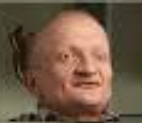
